# Particle Flow Network Classification with tf Dataset

In [1]:
import uproot as ur
import awkward as ak
import numpy as np

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN

2021-08-12 06:31:11.530833: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import sys
sys.path.append('/home/dportill/LCStudies')
from  util import graph_util as gu

In [5]:
# my worspace and directories
path_prefix = '/home/dportill/LCStudies/'
plotpath = path_prefix+'classifier/Plots_EFN/'
modelpath = path_prefix+'classifier/Models_EFN/'

# Load Data

## X

In [14]:
Xraw = np.load('/data/atlas/dportill/X_test2_files.npy', mmap_mode='r')

In [15]:
# shape: (total number of events, total number of cells, [log(E),eta,phi,rperp,sampleID])
Xraw.shape

(7478, 942, 6)

In [20]:
X = np.lib.format.open_memmap('/data/atlas/dportill/X_STSC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 5))
np.copyto(dst=X, src=Xraw[:,:,:5], casting='same_kind', where=True)

## Y

In [7]:
Yraw = np.load('/data/atlas/dportill/Y_test2_files.npy', mmap_mode='r')

In [35]:
# shape: (total number of events, 1) 
Yraw.shape

(7478, 1)

In [36]:
Yraw

memmap([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [38]:
# 1 for pipm and 0 for pi0. First all pipm events, and then for pi0 in a single array
Yraw[:,0]

memmap([1., 1., 1., ..., 0., 0., 0.])

In [39]:
Y = np.lib.format.open_memmap('/data/atlas/dportill/Y_STSC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0]))
np.copyto(dst=Y, src=Yraw[:,0], casting='same_kind', where=True)

In [40]:
Y.shape

(7478,)

* Convert Y to categorical

In [41]:
Y

memmap([1., 1., 1., ..., 0., 0., 0.])

In [42]:
from tensorflow.keras.utils import to_categorical

In [43]:
Y_label = to_categorical(Y)

In [44]:
Y_label

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

* Constructing Y "by hand"  with a label per event and a then a label per cell for testing

In [45]:
Y_list = Y.tolist()

In [50]:
len(Y_list)

7478

In [52]:
pipm_count = Y_list.count(1)
print('pipm events ', pipm_count)

pipm events  3722


In [54]:
pi0_count = Y_list.count(0)
print('pi0 events  ', pi0_count)

pi0 events   3756


In [56]:
Y_label_contructed = tf.keras.utils.to_categorical(np.concatenate((np.ones(pipm_count), np.zeros(pi0_count))))

In [57]:
Y_label_contructed

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [59]:
Y_label.shape

(7478, 2)

In [58]:
Y_label_contructed.shape

(7478, 2)

In [60]:
Y_label

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## tf Dataset

In [61]:
deepSets = tf.data.Dataset.from_tensor_slices((X, Y_label))

2021-08-12 08:25:55.329743: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-12 08:25:55.331548: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-12 08:25:55.480733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:b2:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-12 08:25:55.480806: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-12 08:25:55.488314: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-08-12 08:25:55.488468: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

In [62]:
deepSets

<TensorSliceDataset shapes: ((942, 5), (2,)), types: (tf.float64, tf.float32)>

In [63]:
Total = deepSets.cardinality().numpy()
print("Number of point clouds?: ", Total)

Number of point clouds?:  7478


In [64]:
val= int(Total*0.15)
test= int(Total*0.15)
train=Total-test-val

In [65]:
print("train:", train)
print("test:" ,test)
print("val:" ,val)

train: 5236
test: 1121
val: 1121


In [66]:
ds_train = deepSets.skip(val+test)

In [67]:
ds_test = deepSets.take(test+val)
ds_val = ds_test.skip(test)
ds_test = ds_test.take(test)

In [68]:
print(ds_train.cardinality())
print(ds_val.cardinality())
print(ds_test.cardinality())

tf.Tensor(5236, shape=(), dtype=int64)
tf.Tensor(1121, shape=(), dtype=int64)
tf.Tensor(1121, shape=(), dtype=int64)


## Determine number of batches

In [69]:
batch_size = 1000

Nevts = len(X)
Nbatches = int(np.floor(Nevts/batch_size))
print(Nbatches)


7


In [70]:
ds_train = ds_train.batch(Nbatches, drop_remainder=True)
ds_val = ds_val.batch(Nbatches, drop_remainder=True)
ds_test = ds_test.batch(Nbatches, drop_remainder=True)

## The PFN Model 

In [71]:
# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

In [72]:
X.shape[-1]

5

In [73]:
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

## TRAIN

In [74]:
import time as t

In [75]:
t0 = t.time()
history = pfn.fit(ds_train,
        epochs=100,
        validation_data=ds_val,
        verbose=1)
t1 = t.time()

Epoch 1/100


2021-08-12 08:27:12.834039: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-12 08:27:12.859938: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
2021-08-12 08:27:12.934579: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


 45/748 [>.............................] - ETA: 2s - loss: 0.0000e+00 - acc: 1.0000 

2021-08-12 08:27:13.427247: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


748/748 [==============================] - 5s 5ms/step - loss: 190.1428 - acc: 0.9990 - val_loss: 843391.0000 - val_acc: 0.0000e+00
Epoch 2/100
748/748 [==============================] - 4s 5ms/step - loss: 12998.7932 - acc: 0.9761 - val_loss: 568344.1250 - val_acc: 0.0000e+00
Epoch 3/100
748/748 [==============================] - 3s 4ms/step - loss: 9100.0843 - acc: 0.9685 - val_loss: 113216.8750 - val_acc: 0.0000e+00
Epoch 4/100
748/748 [==============================] - 3s 5ms/step - loss: 2366.9539 - acc: 0.9670 - val_loss: 7039.4243 - val_acc: 0.0000e+00
Epoch 5/100
748/748 [==============================] - 3s 4ms/step - loss: 115.1819 - acc: 0.9093 - val_loss: 45.5980 - val_acc: 0.0000e+00
Epoch 6/100
748/748 [==============================] - 3s 5ms/step - loss: 3.1417 - acc: 0.7827 - val_loss: 5.5590 - val_acc: 0.0000e+00
Epoch 7/100
748/748 [==============================] - 3s 5ms/step - loss: 1.0233 - acc: 0.6395 - val_loss: 3.1253 - val_acc: 0.0000e+00
Epoch 8/100
748/748 

In [76]:
print('Time to train: '+str(t1-t0)+' (s)')
print(str((t1-t0)/60)+' (min)')
print(str((t1-t0)/3600)+' (hour)')

Time to train: 366.43888330459595 (s)
6.107314721743266 (min)
0.1017885786957211 (hour)


In [77]:
pfn.save(modelpath+'pfn_tfdataset_test_100ep.h5')

In [78]:
import matplotlib.pyplot as plt

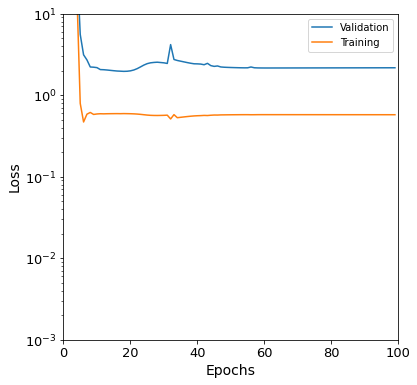

In [79]:

M = len(history.history['val_loss'])
fig = plt.figure(figsize=(6,6))
plt.plot(history.history['val_loss'], label="Validation")
plt.plot(history.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,M)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
# plt.tight_layout()
#plt.savefig('./.png', format='png')
plt.show()

In [40]:
# get area under the ROC curve
preds2 = pfn.predict(ds_test).flatten()

In [41]:
preds2

array([0.8878934 , 0.11210662, 0.8878934 , ..., 0.11210662, 0.8878934 ,
       0.11210662], dtype=float32)

In [42]:
ds_test = ds_test.unbatch()

In [50]:
Npts = len(ds_test)
print(Npts)
Ytest = np.empty(Npts)

1120


In [51]:
Ytest

array([6.90310128e-310, 6.90310128e-310, 4.48208212e-315, ...,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

In [44]:
Ytest = np.empty((Npts,2))

In [80]:
i = 0
for element in ds_test:
    Xi, Yi = element
    #print(Yi)
    #Ytest[i,:] = Yi[:]
    i += 1

In [46]:
Ytest

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
pfn_fp_F90, pfn_tp_F90, threshs_F90 = roc_curve(Ytest, preds2)

ValueError: multilabel-indicator format is not supported

In [79]:
import matplotlib.pyplot as plt

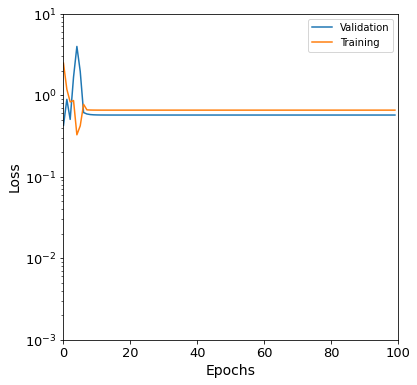

In [82]:

M = len(history.history['val_loss'])
fig = plt.figure(figsize=(6,6))
plt.plot(history.history['val_loss'], label="Validation")
plt.plot(history.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,M)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
# plt.tight_layout()
#plt.savefig('./.png', format='png')
plt.show()